In [1]:
%load_ext autoreload
%autoreload 2
# %config Application.verbose_crash=True

In [2]:
import os
from src.dataclasses.transactions import Transactions
from src.dataclasses.ticker import Ticker
from src.dataclasses.holdings import Holdings
from src.dataclasses.prices import Prices
from src.dataclasses.subscriptions import Subscriptions

from src.utils.defaults import DEFAULT_RFR

## Load in subscriptions

In [3]:
subscriptions = Subscriptions.from_csv(os.getcwd() + "/data/subscriptions.csv")
subscriptions.data.head()

,Portfolio,GBP,USD
Date,,,
2022-08-23,LISA,1993.88,2346.099947
2022-08-24,0,0.00,0.000000
2022-08-25,0,0.00,0.000000
2022-08-26,0,0.00,0.000000
2022-08-27,0,0.00,0.000000


## Load in transactions

In [4]:
transactions = Transactions.from_csv(os.getcwd() + "/data/full_transaction_history.csv")
transactions.raw_data.head()

,Portfolio,Date,Transaction,Description,Quantity,Price,Ticker
0,LISA,2022-08-23,Purchase,GameStop Corp Class A,32,30.00,GME
1,LISA,2022-08-23,Purchase,Vanguard S&P 500 UCITS ETF GBP,15,67.11,VUSA.L
2,LISA,2022-09-02,Purchase,GameStop Corp Class A,82,24.13,GME
3,LISA,2022-10-05,Purchase,GameStop Corp Class A,42,23.09,GME
4,ISA,2022-11-04,Purchase,iShares Core S&P 500 ETF USD Acc GBP,8,345.20,CSP1.L


In [5]:
Ticker("GBPUSD=X", is_fx=True).prices.tail()

Date
2025-11-14    1.315218
2025-11-15    1.315218
2025-11-16    1.315218
2025-11-17    1.316015
2025-11-18    1.316049
Freq: D, Name: GBPUSD=X, dtype: float64

In [6]:
from concurrent.futures import ThreadPoolExecutor


pool = ThreadPoolExecutor(max_workers=10)
prices = Prices(transactions=transactions, pool=pool)
prices.data.tail()

Loading prices: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


,AAPL,GME,MU,GOOG,AMZN,META,ORCL,GXLK.L,DJEL.L,CSP1.L,VUSA.L
Date,,,,,,,,,,,
2025-11-14,272.410004,20.66,246.830002,276.980011,234.690002,609.460022,222.850006,154.735438,479.166918,722.370515,128.046366
2025-11-15,272.410004,20.66,246.830002,276.980011,234.690002,609.460022,222.850006,154.735438,479.166918,722.370515,128.046366
2025-11-16,272.410004,20.66,246.830002,276.980011,234.690002,609.460022,222.850006,154.735438,479.166918,722.370515,128.046366
2025-11-17,267.459991,20.50,241.949997,285.600006,232.869995,602.010010,219.860001,152.605057,476.463103,718.649279,127.377059
2025-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.763756,470.190577,711.910519,126.192578


In [7]:
holdings = Holdings(
    transactions=transactions, prices=prices, subscriptions=subscriptions
)

<Axes: >

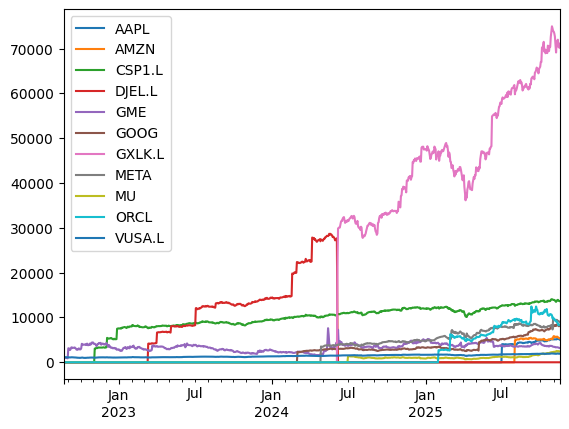

In [8]:
holdings.data.plot()

<Axes: xlabel='Date'>

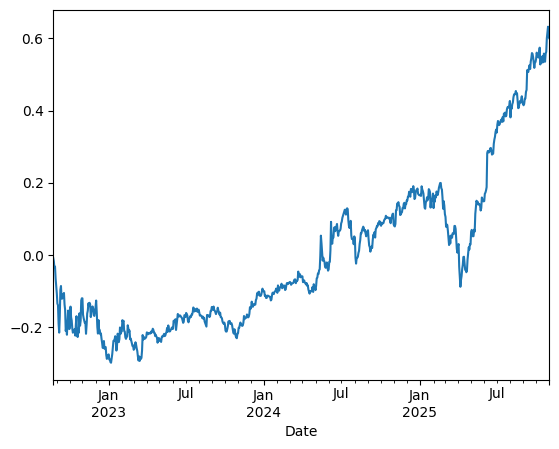

In [9]:
holdings.twr.add(1).cumprod().sub(1).plot()
# holdings.twr[holdings.twr > 0.1].resample("D").sum().fillna(0).plot()

In [10]:
holdings.transactions.data

Ticker,AAPL,AMZN,CSP1.L,DJEL.L,GME,GOOG,GXLK.L,META,MU,ORCL,VUSA.L
2022-08-23,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,15.0
2022-08-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Date'>

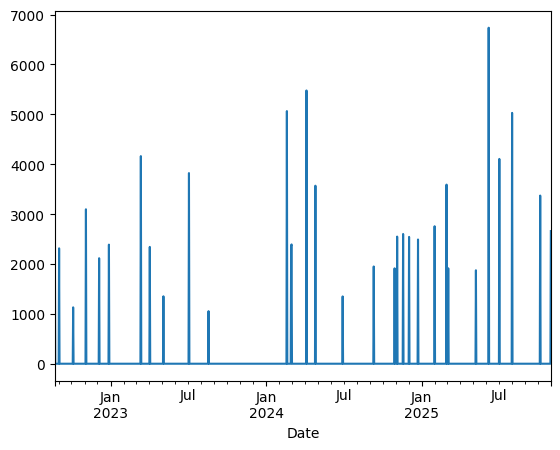

In [11]:
holdings.subscriptions.data["USD"].resample("D").sum().fillna(0).plot()

<Axes: xlabel='Date'>

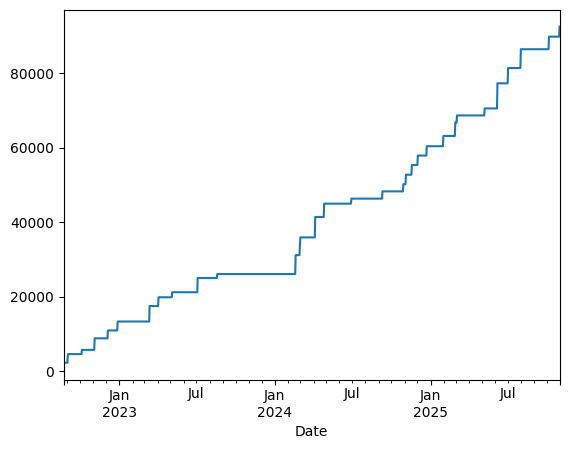

In [12]:
holdings.subscriptions.data["USD"].resample("D").sum().cumsum().fillna(0).plot()

<Axes: >

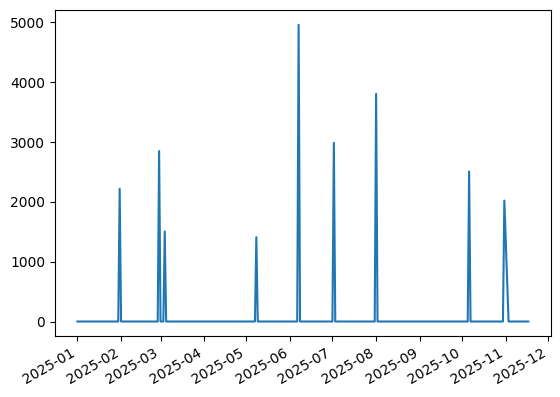

In [13]:
cfs = (
    holdings.subscriptions.data["GBP"]
    # .resample("D")
    # .sum()  # in case of multiple deposits per day
    .reindex(holdings.total.index.union(holdings.subscriptions.data.index))
    .fillna(0.0)
)

cfs["2025":].plot()

In [14]:
holdings.subscriptions.data["GBP"].max()

np.float64(4960.57)

In [15]:
subscriptions.data

,Portfolio,GBP,USD
Date,,,
2022-08-23,LISA,1993.88,2346.099947
2022-08-24,0,0.00,0.000000
2022-08-25,0,0.00,0.000000
2022-08-26,0,0.00,0.000000
2022-08-27,0,0.00,0.000000
...,...,...,...
2025-10-27,0,0.00,0.000000
2025-10-28,0,0.00,0.000000
2025-10-29,0,0.00,0.000000


<Axes: >

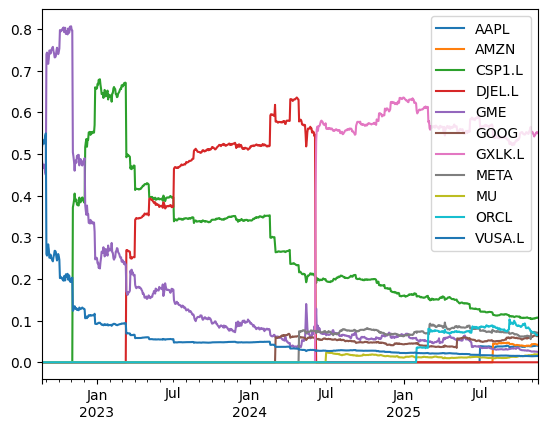

In [16]:
holdings.weights.plot()

In [17]:
from src.constants import YfTickers


bmk = Ticker(YfTickers.SPX).returns
bmk

Date
2015-11-19   -0.001123
2015-11-20    0.003810
2015-11-21    0.000000
2015-11-22    0.000000
2015-11-23   -0.001235
                ...   
2025-11-13   -0.016557
2025-11-14   -0.000502
2025-11-15    0.000000
2025-11-16    0.000000
2025-11-17   -0.009162
Freq: D, Name: ^SPX, Length: 3652, dtype: float64

In [18]:
from src.dataclasses.assessment_config import AssessmentConfig


config = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,
    bmk=bmk,
)

In [19]:
from src.evaluation import Evaluation, ExecutorType

executor = ExecutorType.ProcessPool()
# executor = ExecutorType.Remote("http://localhost:8000")
# executor = ExecutorType.DEFAULT()


In [20]:
# %tb

# executor = ExecutorType.DEFAULT()



e = (Evaluation(config)
    # .with_assessment_types(["summary"]).with_assessments(["Beta"])
    # .with_assessments([AssessmentName.Beta])
    # .with_assessment_types(["rolling"])
    .with_executor(executor=executor)
)




2025-11-18 09:06:58 INFO [src.evaluation] Using ProcessPoolExecutor


In [21]:
r = e.run()
r.timer_report()

2025-11-18 09:06:58 INFO [src.evaluation] Running assessments for configuration: None|Close|^SPX


ASSESSMENT TIMING REPORT

CVaR                |███████                                           | 14.9% |    0.400s |
Skewness            |██████                                            | 13.4% |    0.361s |
Kurtosis            |██████                                            | 12.5% |    0.337s |
Omega Ratio         |█████                                             | 10.1% |    0.272s |
Ulcer Index         |████                                              | 10.0% |    0.268s |
Up Capture          |████                                              |  9.4% |    0.254s |
Down Capture        |████                                              |  9.4% |    0.253s |
Semi-Variance       |███                                               |  7.5% |    0.201s |
M2 Ratio            |██                                                |  5.5% |    0.149s |
Sharpe Ratio        |█                                                 |  3.1% |    0.084s |
Cumulative Returns  |█                      

"============================================================================================\nASSESSMENT TIMING REPORT\n============================================================================================\n\nCVaR                |███████                                           | 14.9% |    0.400s |\nSkewness            |██████                                            | 13.4% |    0.361s |\nKurtosis            |██████                                            | 12.5% |    0.337s |\nOmega Ratio         |█████                                             | 10.1% |    0.272s |\nUlcer Index         |████                                              | 10.0% |    0.268s |\nUp Capture          |████                                              |  9.4% |    0.254s |\nDown Capture        |████                                              |  9.4% |    0.253s |\nSemi-Variance       |███                                               |  7.5% |    0.201s |\nM2 Ratio            |██        

In [22]:
print(r.get_summary_results())

                    None|Close|^SPX
Beta                       0.801488
CAGR                       0.152922
Max Drawdown              -0.292340
Tracking Error             0.221017
Volatility                 0.254604
Correlation                0.512391
VaR                       -0.024394
CVaR                      -0.037178
Up Capture                 0.929495
Down Capture               0.905621
Sharpe Ratio               0.212847
Sortino Ratio              0.313453
Information Ratio          0.038975
Calmar Ratio               0.523097
Treynor Ratio              0.067601
Jensen's Alpha             0.017660
Omega Ratio                1.139033
M2 Ratio                  -0.010929
Skewness                   0.435137
Kurtosis                   5.245014
Semi-Variance              0.022453
R-Squared                  0.262545
Ulcer Index               13.367719
Mean Return                0.174572
Cumulative Returns         0.600603


In [23]:
# Had more capital and more focused on active mgmt
# (switched away from majority holding in DOW)
config_active = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,  # 3mo US Tresury
    bmk=bmk,  # SP500
    start="2024",
)

f_active = Evaluation(config_active).run()
# pd.Series(f_active.results)

2025-11-18 09:07:00 INFO [src.evaluation] Running assessments for configuration: None|Close|^SPX


# Multiple Portfolios

In [24]:
from src.constants import YfTickers


sp500 = Ticker(YfTickers.SPX).returns
qqq = Ticker(YfTickers.QQQ).returns
us_3mo = Ticker(YfTickers.US_3mo).returns
us_10yr = Ticker(YfTickers.US_10yr).returns



In [25]:

multi_asset_config = AssessmentConfig(
    returns=[holdings.twr, holdings.twr["2024":]],
    rfr=[us_3mo, us_10yr],
    bmk=[sp500, qqq],
)

In [26]:
executor = ExecutorType.ProcessPool()
# executor = ExecutorType.Remote("http://localhost:8000")

In [27]:
multi_eval = (
    Evaluation(
        config=multi_asset_config
    )
    .with_executor(executor)
)

2025-11-18 09:07:10 INFO [src.evaluation] Using ProcessPoolExecutor


In [28]:
multi_result = multi_eval.run()
multi_result

2025-11-18 09:07:10 INFO [src.evaluation] Running assessments for configuration: None|^IRX|^SPX
2025-11-18 09:07:12 INFO [src.evaluation] Running assessments for configuration: None|^IRX|QQQ
2025-11-18 09:07:13 INFO [src.evaluation] Running assessments for configuration: None|^TNX|^SPX
2025-11-18 09:07:13 INFO [src.evaluation] Running assessments for configuration: None|^TNX|QQQ
2025-11-18 09:07:14 INFO [src.evaluation] Running assessments for configuration: None|^IRX|^SPX
2025-11-18 09:07:14 INFO [src.evaluation] Running assessments for configuration: None|^IRX|QQQ
2025-11-18 09:07:14 INFO [src.evaluation] Running assessments for configuration: None|^TNX|^SPX
2025-11-18 09:07:15 INFO [src.evaluation] Running assessments for configuration: None|^TNX|QQQ


EvaluationResults(
  configurations=4
  unique_assessments=25
  total_results=300
  overlap_mode=full
)

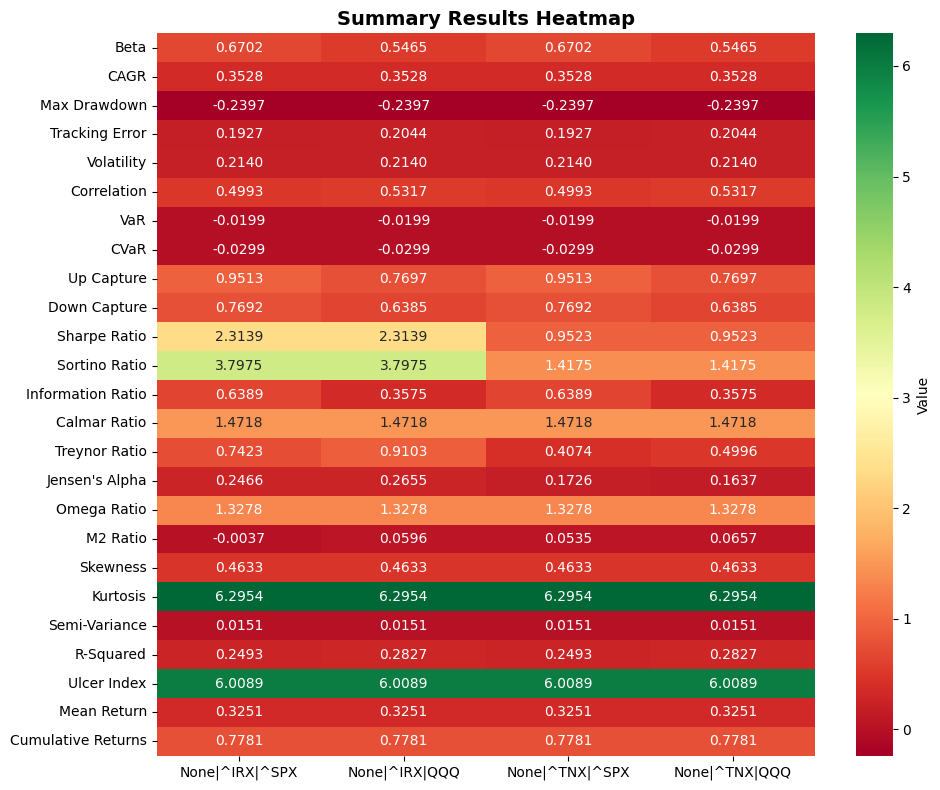

In [30]:
multi_result.results.keys()

dict_keys(['None|^IRX|^SPX', 'None|^IRX|QQQ', 'None|^TNX|^SPX', 'None|^TNX|QQQ'])

In [31]:
multi_result.results['None|^IRX|^SPX'].keys()

dict_keys([<AssessmentName.Beta: 'Beta'>, <AssessmentName.CAGR: 'CAGR'>, <AssessmentName.MaxDrawdown: 'Max Drawdown'>, <AssessmentName.TrackingError: 'Tracking Error'>, <AssessmentName.Volatility: 'Volatility'>, <AssessmentName.Correlation: 'Correlation'>, <AssessmentName.VaR: 'VaR'>, <AssessmentName.CVaR: 'CVaR'>, <AssessmentName.UpCapture: 'Up Capture'>, <AssessmentName.DownCapture: 'Down Capture'>, <AssessmentName.SharpeRatio: 'Sharpe Ratio'>, <AssessmentName.SortinoRatio: 'Sortino Ratio'>, <AssessmentName.InformationRatio: 'Information Ratio'>, <AssessmentName.CalmarRatio: 'Calmar Ratio'>, <AssessmentName.TreynorRatio: 'Treynor Ratio'>, <AssessmentName.JensensAlpha: "Jensen's Alpha">, <AssessmentName.OmegaRatio: 'Omega Ratio'>, <AssessmentName.M2Ratio: 'M2 Ratio'>, <AssessmentName.Skewness: 'Skewness'>, <AssessmentName.Kurtosis: 'Kurtosis'>, <AssessmentName.SemiVariance: 'Semi-Variance'>, <AssessmentName.RSquared: 'R-Squared'>, <AssessmentName.UlcerIndex: 'Ulcer Index'>, <Assessmen

In [32]:
multi_result.results['None|^IRX|^SPX']["Beta"]

{<AssessmentType.Summary: 'summary'>: 0.6702016866154923,
 <AssessmentType.Rolling: 'rolling'>: Date
 2024-01-01         NaN
 2024-01-02         NaN
 2024-01-03         NaN
 2024-01-04         NaN
 2024-01-05         NaN
                 ...   
 2025-10-27    0.615668
 2025-10-28    0.614873
 2025-10-29    0.614747
 2025-10-30    0.619053
 2025-10-31    0.618663
 Freq: B, Length: 480, dtype: float64,
 <AssessmentType.Expanding: 'expanding'>: Date
 2024-01-01         NaN
 2024-01-02         NaN
 2024-01-03         NaN
 2024-01-04         NaN
 2024-01-05         NaN
                 ...   
 2025-10-27    0.667726
 2025-10-28    0.667979
 2025-10-29    0.667827
 2025-10-30    0.670378
 2025-10-31    0.670202
 Freq: B, Length: 480, dtype: float64}